# Manipulate 2021 LSOA boundary data from EW to London

Part of [london-data](https://github.com/jamesdamillington/london-data), by [jamesdamillington](https://github.com/jamesdamillington)

## Aim
Produce a `.csv` containing geometries that can later be joined to other data for analysis. This file will be used by students regularly so should be a relatively small file on disk.

In [1]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2023-11-18


In [2]:
import pyproj
import geopandas as gpd
import shapely
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

## Generalised Boundaries

See [below](#Full) for previous manipulation of the full resolution LSOA boundaries. In 2023, files with boundaries generalised to 20m resolution were released, providing much smaller files appropriate for student use. The code in this first section manipulated these generalised boundaries.

[Generalised (20m) LSOA geometries](https://geoportal.statistics.gov.uk/datasets/ons::lower-layer-super-output-areas-2021-boundaries-ew-bgc/explore) (clipped to the coastline) data downloaded [2023-08-15] as *Lower_layer_Super_Output_Areas_2021_EW_BGC_V3_7972316521517759310.zip*

> Source: Office for National Statistics licensed under the Open Government Licence v.3.0  
Contains OS data © Crown copyright and database right (2022)
Contains both Ordnance Survey and ONS Intellectual Property Rights.

In [3]:
census_ipath = Path("../data/inputs/geographies/census/")
boundaries = gpd.read_file(census_ipath / "Lower_layer_Super_Output_Areas_2021_EW_BGC_V3_7972316521517759310/LSOA_2021_EW_BGC_V3.shp").set_index('LSOA21NM')

In [4]:
boundaries.head()

,LSOA21CD,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
LSOA21NM,,,,,,,
City of London 001A,E01000001,532123,181632,-0.097140,51.5182,1a259a13-a525-4858-9cb0-e4952ba01af6,"POLYGON ((532105.312 182010.574, 532162.491 18..."
City of London 001B,E01000002,532480,181715,-0.091970,51.5188,1233e433-0b0d-4807-8117-17a83c23960d,"POLYGON ((532634.497 181926.016, 532619.141 18..."
City of London 001C,E01000003,532239,182033,-0.095320,51.5217,5163b7cb-4ffe-4f41-95b9-aa6cfc0508a3,"POLYGON ((532135.138 182198.131, 532158.250 18..."
City of London 001E,E01000005,533581,181283,-0.076270,51.5147,2af8015e-386e-456d-a45a-d0a223c340df,"POLYGON ((533808.018 180767.774, 533649.037 18..."
Barking and Dagenham 016A,E01000006,544994,184274,0.089317,51.5387,b492b45e-175e-4e77-b0b5-5b2fd6993ef4,"POLYGON ((545122.049 184314.931, 545271.849 18..."


### Subset to London only
Looks like London LSOAs are listed at the top, so slice down to bottom LSOA (Westminster 013D)

In [5]:
london = boundaries.loc[:'Westminster 013D',:]
london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4506 entries, City of London 001A to Westminster 013D
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA21CD  4506 non-null   object  
 1   BNG_E     4506 non-null   int64   
 2   BNG_N     4506 non-null   int64   
 3   LONG      4506 non-null   float64 
 4   LAT       4506 non-null   float64 
 5   GlobalID  4506 non-null   object  
 6   geometry  4506 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 281.6+ KB


<AxesSubplot:>

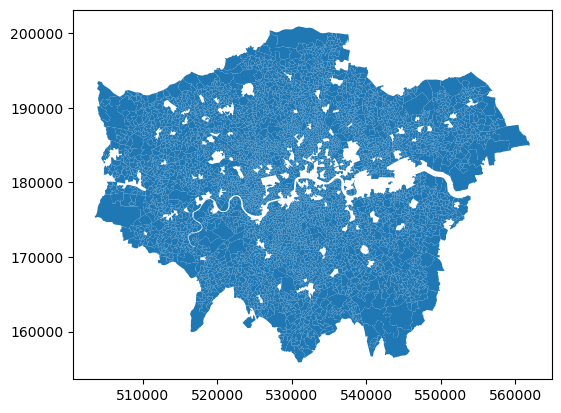

In [6]:
london.plot()

Unfortunately, we have missing polygons - so maybe the LSOAs are not sorted well and there are London LSOAs further down the DataFrame. So, we should select LSOAs based on borough names (plus City). 

Get borough names from [OA-LSOA-MSOA-LAD (2021) lookup](https://geoportal.statistics.gov.uk/datasets/output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-december-2021-lookup-in-england-and-wales-v2/about) (downloaded [2022-08-24])
> Source: Office for National Statistics licensed under the Open Government Licence v.3.0

We'll use this lookup again later to join MSOA and LAD codes and names

In [7]:
sam = pd.read_csv(census_ipath / "OA21_LSOA21_MSOA21_LAD22_EW_LU.csv", encoding='iso8859_15')  #set encoding to avoid error in last column
sam.columns = sam.columns.str.upper()        #convert column names to upper case for consistency
sam.drop('LAD22NMW', axis=1, inplace=True)   #drop welsh names (not needed for London)
sam.head()

/tmp/ipykernel_10707/1333758577.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  sam = pd.read_csv(census_ipath / "OA21_LSOA21_MSOA21_LAD22_EW_LU.csv", encoding='iso8859_15')  #set encoding to avoid error in last column


,OA21CD,LSOA21CD,LSOA21NM,MSOA21CD,MSOA21NM,LAD22CD,LAD22NM
0,E00000001,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London
1,E00000003,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London
2,E00000005,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London
3,E00000007,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London
4,E00000010,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London


In [8]:
lads = pd.unique(sam.LAD22NM)
lads

array(['City of London', 'Barking and Dagenham', 'Barnet', 'Bexley',
       'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey',
       'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Newham', 'Redbridge',
       'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Westminster', 'Bolton', 'Bury',
       'Manchester', 'Oldham', 'Rochdale', 'Salford', 'Stockport',
       'Tameside', 'Trafford', 'Wigan', 'Knowsley', 'Liverpool',
       'St. Helens', 'Sefton', 'Wirral', 'Barnsley', 'Doncaster',
       'Rotherham', 'Sheffield', 'Gateshead', 'Newcastle upon Tyne',
       'North Tyneside', 'South Tyneside', 'Sunderland', 'Birmingham',
       'Coventry', 'Dudley', 'Sandwell', 'Solihull', 'Walsall',
       'Wolverhampton', 'Bradford', 'Calderdale', 'Kirklees'

From this we can see London boroughs _are_ listed first, so we can get list of borough names relatively easily:

In [9]:
lads = list(lads)
london_lads = lads[:lads.index('Westminster')+1]
london_lads

['City of London',
 'Barking and Dagenham',
 'Barnet',
 'Bexley',
 'Brent',
 'Bromley',
 'Camden',
 'Croydon',
 'Ealing',
 'Enfield',
 'Greenwich',
 'Hackney',
 'Hammersmith and Fulham',
 'Haringey',
 'Harrow',
 'Havering',
 'Hillingdon',
 'Hounslow',
 'Islington',
 'Kensington and Chelsea',
 'Kingston upon Thames',
 'Lambeth',
 'Lewisham',
 'Merton',
 'Newham',
 'Redbridge',
 'Richmond upon Thames',
 'Southwark',
 'Sutton',
 'Tower Hamlets',
 'Waltham Forest',
 'Wandsworth',
 'Westminster']

In [10]:
len(london_lads)

33

We want to use the LSOA names as a Series below, so extract them from index (and set `dtype` to string)

In [11]:
boundaries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 35672 entries, City of London 001A to Vale of Glamorgan 015F
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA21CD  35672 non-null  object  
 1   BNG_E     35672 non-null  int64   
 2   BNG_N     35672 non-null  int64   
 3   LONG      35672 non-null  float64 
 4   LAT       35672 non-null  float64 
 5   GlobalID  35672 non-null  object  
 6   geometry  35672 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 3.2+ MB


In [12]:
boundaries = boundaries.reset_index()
boundaries['LSOA21NM'] = boundaries['LSOA21NM'].astype('string')

Now filter to retain only rows for _LSOA21NM_ that contain some text in the _london_lads_ list (do shallow copy to avoid index issue later)

In [13]:
london = boundaries[boundaries['LSOA21NM'].str.contains("|".join(london_lads))]   #from https://stackoverflow.com/a/71399966
london = london.copy(deep=False)
london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5042 entries, 0 to 33715
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA21NM  5042 non-null   string  
 1   LSOA21CD  5042 non-null   object  
 2   BNG_E     5042 non-null   int64   
 3   BNG_N     5042 non-null   int64   
 4   LONG      5042 non-null   float64 
 5   LAT       5042 non-null   float64 
 6   GlobalID  5042 non-null   object  
 7   geometry  5042 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(2), string(1)
memory usage: 354.5+ KB


Plot to check

<AxesSubplot:>

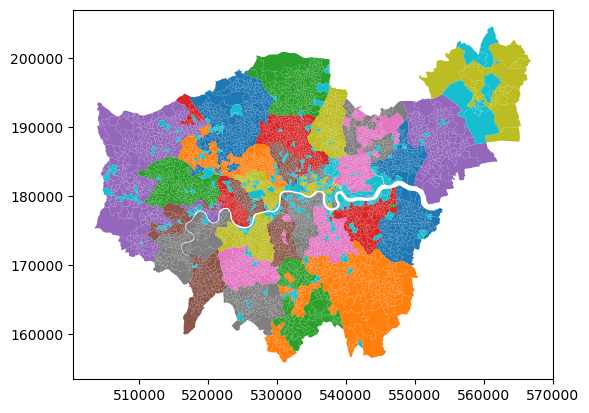

In [14]:
london.plot('LSOA21CD')

What's going on here? We have some unexpected LSOAs in north east. Let's plot each 'borough' in turn to investigate:

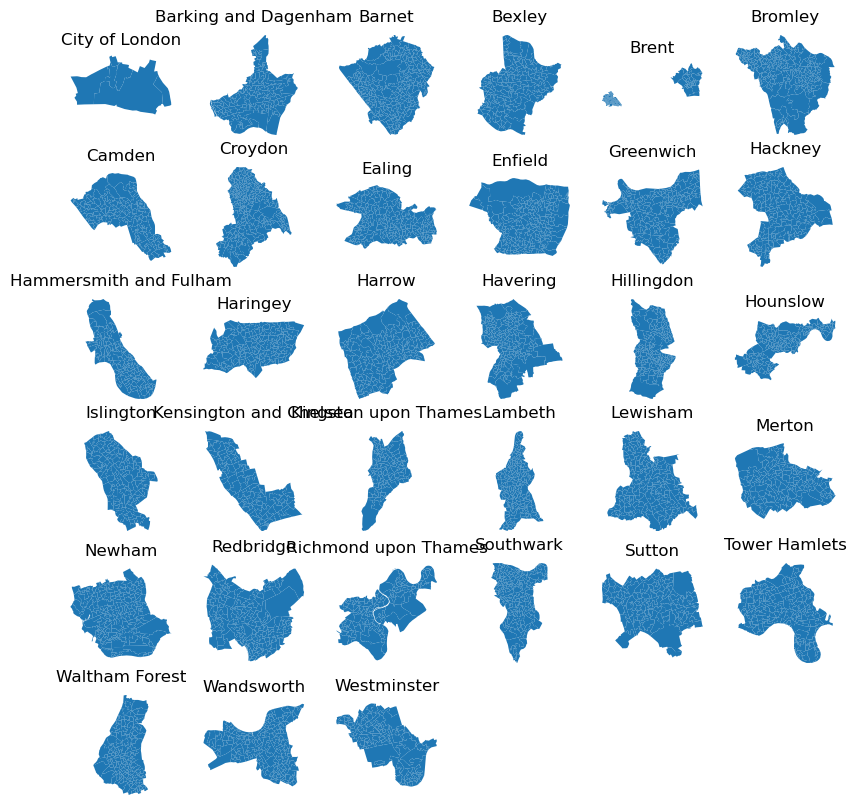

In [15]:
fig, axs = plt.subplots(6,6,figsize=(10,10))
row = 0
col = 0

for i, x in enumerate(london_lads):
    l = london[london['LSOA21NM'].str.contains(x)]
    
    col = i%6
    theax=axs[row][col]

    ax = l.plot(ax=theax)
    theax.set_title(x)
    theax.axis('off')
    
    if col == 5: 
        row += 1

for ax in axs.flat[len(london_lads):]:
    ax.remove()
    
plt.show()

It looks like Brent is the problem, as it has been split into two! 

<AxesSubplot:>

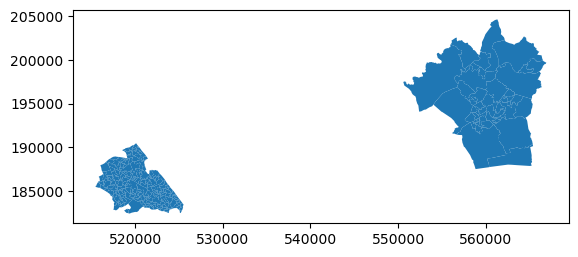

In [16]:
london[london['LSOA21NM'].str.contains('Brent')].plot()

In [17]:
london[london['LSOA21NM'].str.contains('Brent')]

,LSOA21NM,LSOA21CD,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
454,Brent 026A,E01000471,518589,183431,-0.291500,51.5373,a5f90072-5166-4924-870f-a2394582c82a,"POLYGON ((518728.138 183645.948, 518850.546 18..."
455,Brent 029A,E01000472,518001,183293,-0.300020,51.5362,8e6cb3f0-294f-48d0-957b-72fb4b048924,"POLYGON ((518089.015 183692.578, 518082.861 18..."
456,Brent 029B,E01000473,518316,184162,-0.295190,51.5440,3391e1a6-a2dc-4aca-9781-feda8ffe1e89,"POLYGON ((518402.056 184434.910, 518286.736 18..."
457,Brent 026B,E01000474,518642,184407,-0.290410,51.5461,05c91919-3a94-4222-917f-b64ac715df75,"POLYGON ((518928.910 184521.207, 518919.483 18..."
458,Brent 029C,E01000475,517571,184055,-0.305960,51.5432,9224152b-1703-46a6-b819-8827a6ee8913,"POLYGON ((518034.789 183756.795, 517959.000 18..."
...,...,...,...,...,...,...,...,...
31983,Brent 035D,E01033942,519249,185642,-0.281240,51.5571,50e2288f-39c5-446f-a55e-67b14405a89d,"POLYGON ((519284.223 185850.386, 519284.544 18..."
32396,Brentwood 007H,E01034358,559779,193786,0.306651,51.6202,81c4f1a9-ba49-46f5-a1bf-b3b568d09985,"POLYGON ((560076.000 193700.000, 560002.000 19..."
32397,Brentwood 007I,E01034359,558869,193560,0.293415,51.6184,f35408e1-7171-4091-b58b-784bbbc859d3,"POLYGON ((559267.097 193438.573, 559314.000 19..."
32398,Brentwood 007J,E01034360,559687,193313,0.305108,51.6160,49d77daa-73d6-487e-b37f-483378366afa,"POLYGON ((559722.122 193627.327, 559696.468 19..."


Last few rows show that Brentwood is being included as well as Brent!  So filter Brentwood out

In [18]:
london_noBrentwood = london[~london['LSOA21NM'].str.contains('Brentwood')]

In [19]:
london_noBrentwood.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4994 entries, 0 to 33715
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA21NM  4994 non-null   string  
 1   LSOA21CD  4994 non-null   object  
 2   BNG_E     4994 non-null   int64   
 3   BNG_N     4994 non-null   int64   
 4   LONG      4994 non-null   float64 
 5   LAT       4994 non-null   float64 
 6   GlobalID  4994 non-null   object  
 7   geometry  4994 non-null   geometry
dtypes: float64(2), geometry(1), int64(2), object(2), string(1)
memory usage: 351.1+ KB


<AxesSubplot:>

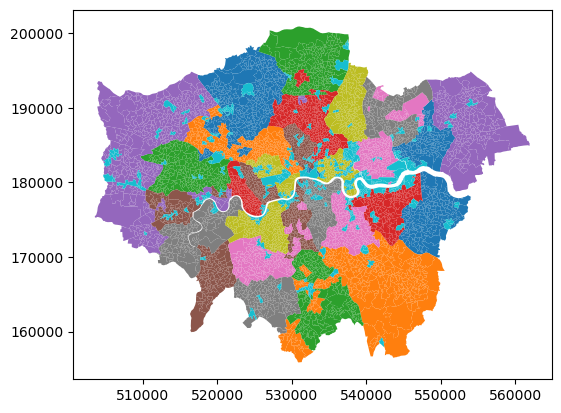

In [20]:
london_noBrentwood.plot('LSOA21CD')

This looks like the extent of greater London. 

### Join MSOA and LAD info

In [21]:
sam.drop('OA21CD', axis=1, inplace=True)
sam.drop_duplicates(subset=['LSOA21NM'], inplace=True)

In [22]:
sam.head()

,LSOA21CD,LSOA21NM,MSOA21CD,MSOA21NM,LAD22CD,LAD22NM
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London
4,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London
6,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London
12,E01032739,City of London 001F,E02000001,City of London 001,E09000001,City of London
13,E01032740,City of London 001G,E02000001,City of London 001,E09000001,City of London


In [23]:
merge_london = pd.merge(london_noBrentwood, sam, how='left', on='LSOA21CD')

In [24]:
merge_london = merge_london[['LSOA21CD', 'LSOA21NM_x', 'MSOA21CD', 'MSOA21NM', 'LAD22CD', 'LAD22NM', 'geometry']]
merge_london.rename(columns = {'LSOA21NM_x':'LSOA21NM'}, inplace = True)
merge_london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4994 entries, 0 to 4993
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA21CD  4994 non-null   object  
 1   LSOA21NM  4994 non-null   string  
 2   MSOA21CD  4994 non-null   object  
 3   MSOA21NM  4994 non-null   object  
 4   LAD22CD   4994 non-null   object  
 5   LAD22NM   4994 non-null   object  
 6   geometry  4994 non-null   geometry
dtypes: geometry(1), object(5), string(1)
memory usage: 312.1+ KB


Write to file

In [25]:
census_opath = Path("../data/geographies/census/")
merge_london.to_file(census_opath / "london-2021-lsoa-gen20.shp")

/home/james/anaconda3/envs/london-data/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [26]:
merge_london.to_csv(census_opath / "london-2021-lsoa-gen20.csv", index=False)  

csv written is ~6MB

### Final checks

Read back in to check:

In [27]:
#https://gist.github.com/jamesdamillington/5f7c4c231b74a068be4cb232b1b9dea5
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads

file_path = census_opath / "london-2021-lsoa-gen20.csv"
geom_col = 'geometry'
epsg_id = 27700
crs_str = "EPSG:" + str(epsg_id) 

df = pd.read_csv(file_path)
gdf = gpd.GeoDataFrame(df)  #geopandas
gdf[geom_col] = gdf[geom_col].apply(lambda x: loads(x))  #from shapely
gdf = gdf.set_geometry(geom_col).set_crs(crs_str)

In [28]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA21CD  4994 non-null   object  
 1   LSOA21NM  4994 non-null   object  
 2   MSOA21CD  4994 non-null   object  
 3   MSOA21NM  4994 non-null   object  
 4   LAD22CD   4994 non-null   object  
 5   LAD22NM   4994 non-null   object  
 6   geometry  4994 non-null   geometry
dtypes: geometry(1), object(6)
memory usage: 273.2+ KB


<AxesSubplot:>

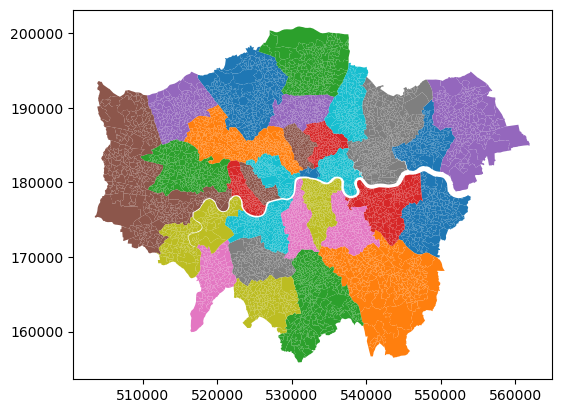

In [29]:
gdf.plot(column='LAD22CD')

<AxesSubplot:>

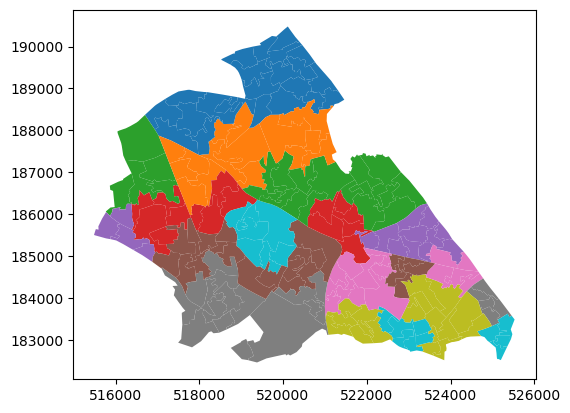

In [30]:
gdf[gdf['LSOA21NM'].str.contains('Brent')].plot(column='MSOA21NM')

## Create Borough Boundaries Shapefile

Use geopandas [dissolve](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.dissolve.html) method. 


In [31]:
gdf_lad = gdf.dissolve(by='LAD22NM', as_index=False)

In [32]:
gdf_lad.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LAD22NM   33 non-null     object  
 1   geometry  33 non-null     geometry
 2   LSOA21CD  33 non-null     object  
 3   LSOA21NM  33 non-null     object  
 4   MSOA21CD  33 non-null     object  
 5   MSOA21NM  33 non-null     object  
 6   LAD22CD   33 non-null     object  
dtypes: geometry(1), object(6)
memory usage: 1.9+ KB


<AxesSubplot:>

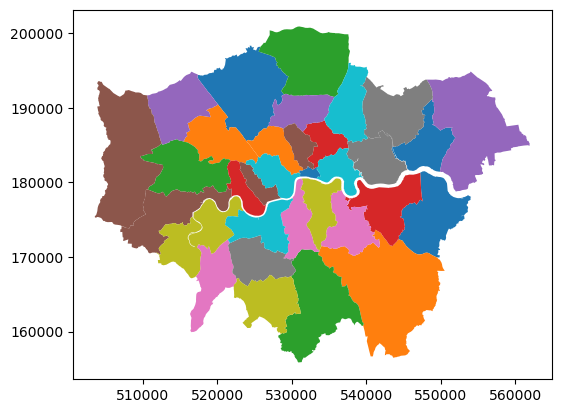

In [33]:
gdf_lad.plot(column='LSOA21CD')

In [34]:
gdf_lad = gdf_lad[['LAD22NM', 'LAD22CD', 'geometry']]

In [35]:
gdf_lad.to_file(census_opath / "london-2021-lad22-gen20.shp")

/home/james/anaconda3/envs/london-data/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Create MSOA Boundaries Shapefile

Use geopandas [dissolve](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.dissolve.html) method. 

In [36]:
gdf_msoa = gdf.dissolve(by='MSOA21NM', as_index=False)

In [37]:
gdf_msoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   MSOA21NM  1002 non-null   object  
 1   geometry  1002 non-null   geometry
 2   LSOA21CD  1002 non-null   object  
 3   LSOA21NM  1002 non-null   object  
 4   MSOA21CD  1002 non-null   object  
 5   LAD22CD   1002 non-null   object  
 6   LAD22NM   1002 non-null   object  
dtypes: geometry(1), object(6)
memory usage: 54.9+ KB


<AxesSubplot:>

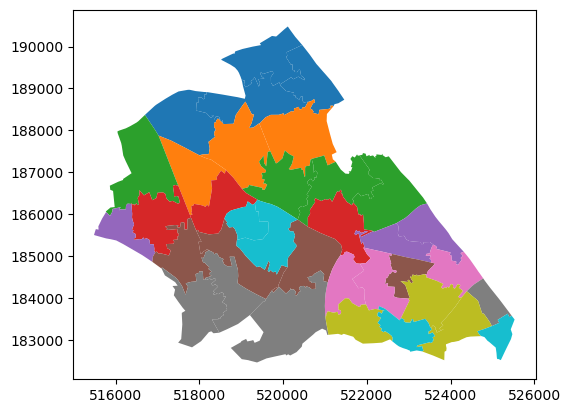

In [38]:
gdf_msoa[gdf_msoa['LSOA21NM'].str.contains('Brent')].plot(column='MSOA21CD')

In [39]:
gdf_msoa = gdf_msoa[['MSOA21NM', 'MSOA21CD', 'geometry']]

In [40]:
gdf_msoa.to_file(census_opath / "london-2021-msoa-gen20.shp")

/home/james/anaconda3/envs/london-data/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<a id='Full'></a>
## Full Resolution Boundaries 

[LSOA geometries](https://geoportal.statistics.gov.uk/datasets/ons::lower-layer-super-output-areas-december-2021-boundaries-full-clipped-ew-bfc/about) data downloaded [2022-08-22] as *Lower_layer_Super_Output_Areas_(December_2021)_Boundaries_Full_Clipped_EW_(BFC).zip*

> Source: Office for National Statistics licensed under the Open Government Licence v.3.0  
Contains OS data © Crown copyright and database right (2022)

In [41]:
census_ipath = Path("../data/inputs/geographies/census/")
boundaries = gpd.read_file(census_ipath / "Lower_layer_Super_Output_Areas_(December_2021)_Boundaries_Full_Clipped_EW_(BFC)/LSOA_2021_EW_BFC_V7.shp").set_index('LSOA21NM')

In [42]:
boundaries.head()

,OBJECTID,LSOA21CD,SHAPE_Leng,SHAPE_Area,geometry
LSOA21NM,,,,,
City of London 001A,1,E01000001,2635.767993,129865.314435,"POLYGON ((532151.537 181867.433, 532152.500 18..."
City of London 001B,2,E01000002,2707.816821,228419.782304,"POLYGON ((532634.497 181926.016, 532632.048 18..."
City of London 001C,3,E01000003,1224.573160,59054.204611,"POLYGON ((532153.703 182165.155, 532158.250 18..."
City of London 001E,4,E01000005,2275.805344,189577.709493,"POLYGON ((533619.062 181402.364, 533639.868 18..."
Barking and Dagenham 016A,5,E01000006,1966.092607,146536.995720,"POLYGON ((545126.852 184310.838, 545145.213 18..."


### Subset to London only
Looks like London LSOAs are listed at the top, so slice down to bottom LSOA (Westminster 013D)

In [43]:
london = boundaries.loc[:'Westminster 013D',:]
london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4506 entries, City of London 001A to Westminster 013D
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    4506 non-null   int64   
 1   LSOA21CD    4506 non-null   object  
 2   SHAPE_Leng  4506 non-null   float64 
 3   SHAPE_Area  4506 non-null   float64 
 4   geometry    4506 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 211.2+ KB


<AxesSubplot:>

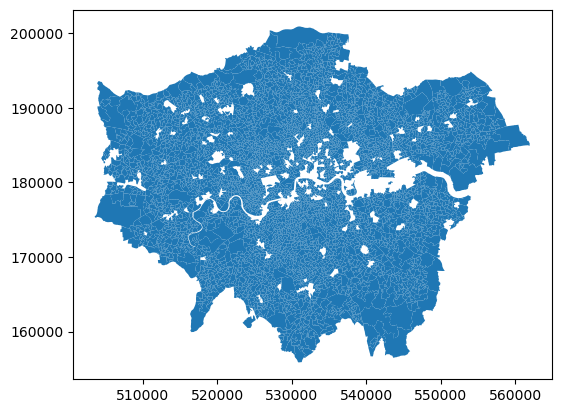

In [44]:
london.plot()

Unfortunately, we have missing polygons - so maybe the LSOAs are not sorted well and there are London LSOAs further down the DataFrame. So, we should select LSOAs based on borough names (plus City). 

Get borough names from [OA-LSOA-MSOA-LAD (2021) lookup](https://geoportal.statistics.gov.uk/datasets/output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-december-2021-lookup-in-england-and-wales-v2/about) (downloaded [2022-08-24])
> Source: Office for National Statistics licensed under the Open Government Licence v.3.0

We'll use this lookup again later to join MSOA and LAD codes and names

In [45]:
sam = pd.read_csv(census_ipath / "OA21_LSOA21_MSOA21_LAD22_EW_LU.csv", encoding='iso8859_15')  #set encoding to avoid error in last column
sam.columns = sam.columns.str.upper()        #convert column names to upper case for consistency
sam.drop('LAD22NMW', axis=1, inplace=True)   #drop welsh names (not needed for London)
sam.head()

/tmp/ipykernel_10707/1333758577.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  sam = pd.read_csv(census_ipath / "OA21_LSOA21_MSOA21_LAD22_EW_LU.csv", encoding='iso8859_15')  #set encoding to avoid error in last column


,OA21CD,LSOA21CD,LSOA21NM,MSOA21CD,MSOA21NM,LAD22CD,LAD22NM
0,E00000001,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London
1,E00000003,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London
2,E00000005,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London
3,E00000007,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London
4,E00000010,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London


In [46]:
lads = pd.unique(sam.LAD22NM)
lads

array(['City of London', 'Barking and Dagenham', 'Barnet', 'Bexley',
       'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey',
       'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Newham', 'Redbridge',
       'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Westminster', 'Bolton', 'Bury',
       'Manchester', 'Oldham', 'Rochdale', 'Salford', 'Stockport',
       'Tameside', 'Trafford', 'Wigan', 'Knowsley', 'Liverpool',
       'St. Helens', 'Sefton', 'Wirral', 'Barnsley', 'Doncaster',
       'Rotherham', 'Sheffield', 'Gateshead', 'Newcastle upon Tyne',
       'North Tyneside', 'South Tyneside', 'Sunderland', 'Birmingham',
       'Coventry', 'Dudley', 'Sandwell', 'Solihull', 'Walsall',
       'Wolverhampton', 'Bradford', 'Calderdale', 'Kirklees'

From this we can see London boroughs _are_ listed first, so we can get list of borough names relatively easily:

In [47]:
lads = list(lads)
london_lads = lads[:lads.index('Westminster')+1]
london_lads

['City of London',
 'Barking and Dagenham',
 'Barnet',
 'Bexley',
 'Brent',
 'Bromley',
 'Camden',
 'Croydon',
 'Ealing',
 'Enfield',
 'Greenwich',
 'Hackney',
 'Hammersmith and Fulham',
 'Haringey',
 'Harrow',
 'Havering',
 'Hillingdon',
 'Hounslow',
 'Islington',
 'Kensington and Chelsea',
 'Kingston upon Thames',
 'Lambeth',
 'Lewisham',
 'Merton',
 'Newham',
 'Redbridge',
 'Richmond upon Thames',
 'Southwark',
 'Sutton',
 'Tower Hamlets',
 'Waltham Forest',
 'Wandsworth',
 'Westminster']

In [48]:
len(london_lads)

33

We want to use the LSOA names as a Series below, so extract them from index (and set `dtype` to string)

In [49]:
boundaries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 35672 entries, City of London 001A to Vale of Glamorgan 015F
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    35672 non-null  int64   
 1   LSOA21CD    35672 non-null  object  
 2   SHAPE_Leng  35672 non-null  float64 
 3   SHAPE_Area  35672 non-null  float64 
 4   geometry    35672 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 2.6+ MB


In [50]:
boundaries = boundaries.reset_index()
boundaries.drop('OBJECTID', axis=1, inplace=True)
boundaries['LSOA21NM'] = boundaries['LSOA21NM'].astype('string')

Now filter to retain only rows for _LSOA21NM_ that contain some text in the _london_lads_ list (do shallow copy to avoid index issue later)

In [51]:
london = boundaries[boundaries['LSOA21NM'].str.contains("|".join(london_lads))]   #from https://stackoverflow.com/a/71399966
london = london.copy(deep=False)
london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5042 entries, 0 to 33715
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   LSOA21NM    5042 non-null   string  
 1   LSOA21CD    5042 non-null   object  
 2   SHAPE_Leng  5042 non-null   float64 
 3   SHAPE_Area  5042 non-null   float64 
 4   geometry    5042 non-null   geometry
dtypes: float64(2), geometry(1), object(1), string(1)
memory usage: 236.3+ KB


Plot to check

<AxesSubplot:>

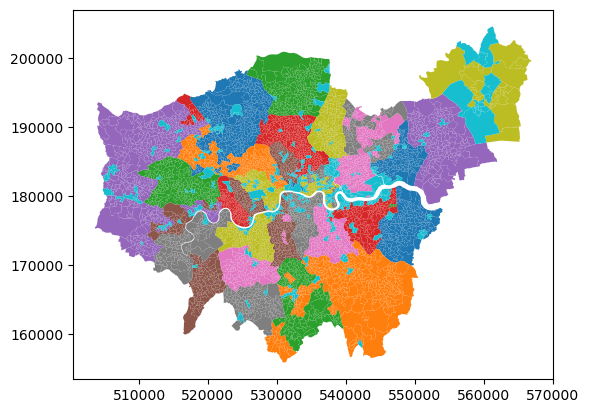

In [52]:
london.plot('LSOA21CD')

What's going on here? We have some unexpected LSOAs in north east. Let's plot each 'borough' in turn to investigate:

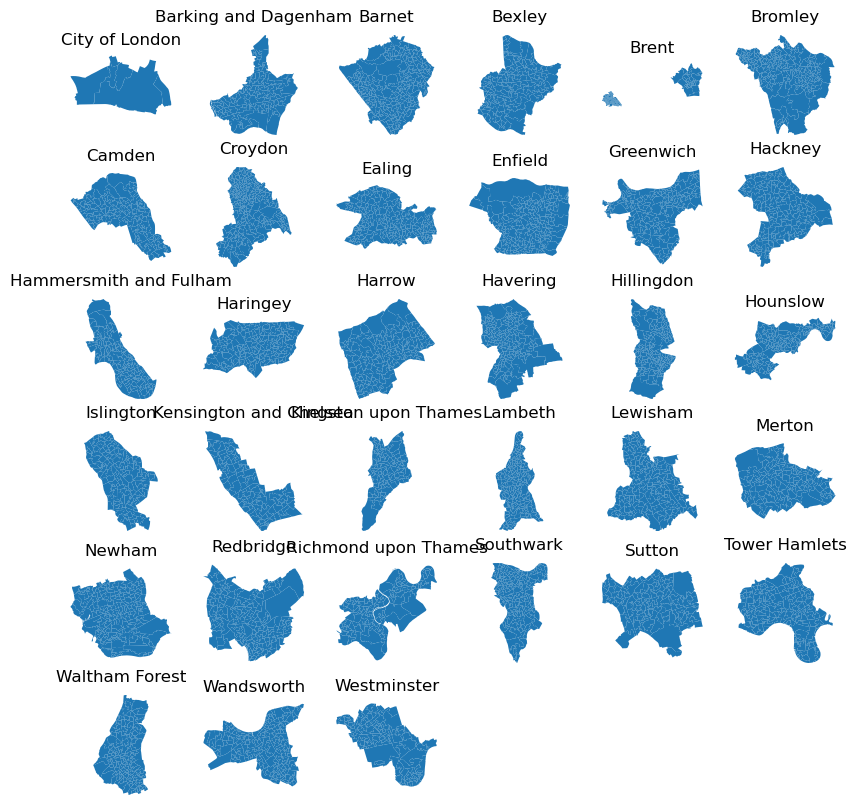

In [53]:
fig, axs = plt.subplots(6,6,figsize=(10,10))
row = 0
col = 0

for i, x in enumerate(london_lads):
    l = london[london['LSOA21NM'].str.contains(x)]
    
    col = i%6
    theax=axs[row][col]

    ax = l.plot(ax=theax)
    theax.set_title(x)
    theax.axis('off')
    
    if col == 5: 
        row += 1

for ax in axs.flat[len(london_lads):]:
    ax.remove()
    
plt.show()

It looks like Brent is the problem, as it has been split into two! 

<AxesSubplot:>

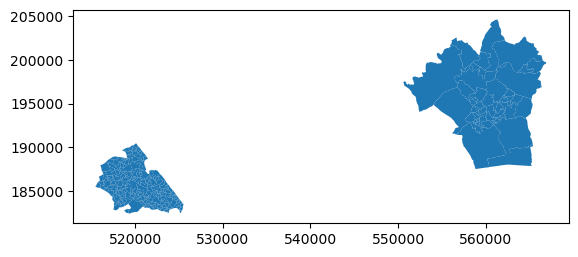

In [54]:
london[london['LSOA21NM'].str.contains('Brent')].plot()

In [55]:
london[london['LSOA21NM'].str.contains('Brent')]

,LSOA21NM,LSOA21CD,SHAPE_Leng,SHAPE_Area,geometry
454,Brent 026A,E01000471,1858.770681,139033.027206,"POLYGON ((518816.208 183497.387, 518817.814 18..."
455,Brent 029A,E01000472,3503.473350,432847.246455,"POLYGON ((518119.033 183705.224, 518098.000 18..."
456,Brent 029B,E01000473,3775.527656,173634.719432,"POLYGON ((518402.056 184434.910, 518389.653 18..."
457,Brent 026B,E01000474,3091.453160,196455.352914,"POLYGON ((518453.219 184653.437, 518455.625 18..."
458,Brent 029C,E01000475,4062.550728,312195.150359,"POLYGON ((518033.000 183755.000, 518000.000 18..."
...,...,...,...,...,...
31983,Brent 035D,E01033942,3305.458563,284149.257375,"POLYGON ((519162.251 185932.450, 519162.777 18..."
32396,Brentwood 007H,E01034358,2955.344792,283821.841354,"POLYGON ((560074.530 193996.531, 560074.562 19..."
32397,Brentwood 007I,E01034359,3453.652901,368228.654680,"POLYGON ((558727.608 193992.528, 558760.923 19..."
32398,Brentwood 007J,E01034360,2980.162461,415990.817409,"POLYGON ((559710.643 193632.117, 559711.713 19..."


Last few rows show that Brentwood is being included as well as Brent!  So filter Brentwood out

In [56]:
london_noBrentwood = london[~london['LSOA21NM'].str.contains('Brentwood')]

In [57]:
london_noBrentwood.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4994 entries, 0 to 33715
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   LSOA21NM    4994 non-null   string  
 1   LSOA21CD    4994 non-null   object  
 2   SHAPE_Leng  4994 non-null   float64 
 3   SHAPE_Area  4994 non-null   float64 
 4   geometry    4994 non-null   geometry
dtypes: float64(2), geometry(1), object(1), string(1)
memory usage: 234.1+ KB


<AxesSubplot:>

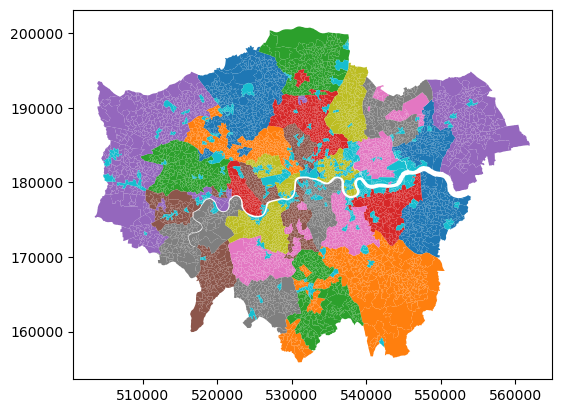

In [58]:
london_noBrentwood.plot('LSOA21CD')

This looks like the extent of greater London. 

### Join MSOA and LAD info

In [59]:
sam.drop('OA21CD', axis=1, inplace=True)
sam.drop_duplicates(subset=['LSOA21NM'], inplace=True)

In [60]:
sam.head()

,LSOA21CD,LSOA21NM,MSOA21CD,MSOA21NM,LAD22CD,LAD22NM
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London
4,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London
6,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London
12,E01032739,City of London 001F,E02000001,City of London 001,E09000001,City of London
13,E01032740,City of London 001G,E02000001,City of London 001,E09000001,City of London


In [61]:
merge_london = pd.merge(london_noBrentwood, sam, how='left', on='LSOA21CD')

In [62]:
merge_london = merge_london[['LSOA21CD', 'LSOA21NM_x', 'MSOA21CD', 'MSOA21NM', 'LAD22CD', 'LAD22NM', 'geometry']]
merge_london.rename(columns = {'LSOA21NM_x':'LSOA21NM'}, inplace = True)
merge_london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4994 entries, 0 to 4993
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA21CD  4994 non-null   object  
 1   LSOA21NM  4994 non-null   string  
 2   MSOA21CD  4994 non-null   object  
 3   MSOA21NM  4994 non-null   object  
 4   LAD22CD   4994 non-null   object  
 5   LAD22NM   4994 non-null   object  
 6   geometry  4994 non-null   geometry
dtypes: geometry(1), object(5), string(1)
memory usage: 312.1+ KB


In [63]:
census_opath = Path("../data/geographies/census/")
merge_london.to_file(census_opath / "london-2021-lsoa.shp")

/home/james/anaconda3/envs/london-data/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [64]:
#merge_london.to_csv(census_opath / "london-2021-lsoa.csv")  #not written as large file size

## Simplify Full Resolution Geometries
Data files written to file (from full resolution boundaries) are quite large (~40MB for .shp and ~85MB for .csv). Use GeoPandas.simplify to reduce file size.

First check CRS of the file to understand units for tolerance parameter. 

In [65]:
merge_london.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [66]:
merge_london_simple = merge_london.copy(deep=False)
merge_london_simple.geometry = merge_london.simplify(tolerance=10)
merge_london_simple.head()

,LSOA21CD,LSOA21NM,MSOA21CD,MSOA21NM,LAD22CD,LAD22NM,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532151.537 181867.433, 532308.875 18..."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532634.497 181926.016, 532618.688 18..."
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532153.703 182165.155, 532158.250 18..."
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,"POLYGON ((533619.062 181402.364, 533765.806 18..."
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,"POLYGON ((545126.852 184310.838, 545296.239 18..."


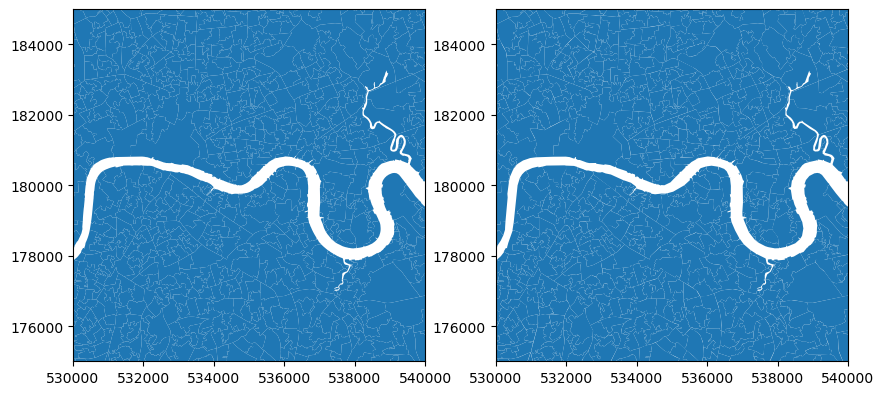

In [67]:
custom_xlim=(530000,540000)
custom_ylim=(175000,185000)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
merge_london.plot(ax=ax[0])
merge_london_simple.plot(ax=ax[1])
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
plt.show()

Simplifying with `tolerance=10` seems to have limitied impact on visualisation at intermediate scales.

We can see some impact at fine scales

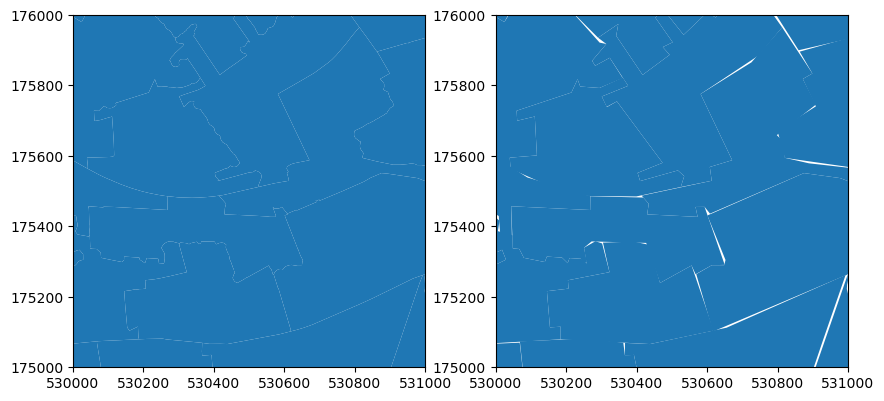

In [68]:
custom_xlim=(530000,531000)
custom_ylim=(175000,176000)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
merge_london.plot(ax=ax[0])
merge_london_simple.plot(ax=ax[1])
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
plt.show()

But at Borough level, visualisation is fine. We'll use this tolerance (if students want to use the original we can make that available as .shp).

<AxesSubplot:>

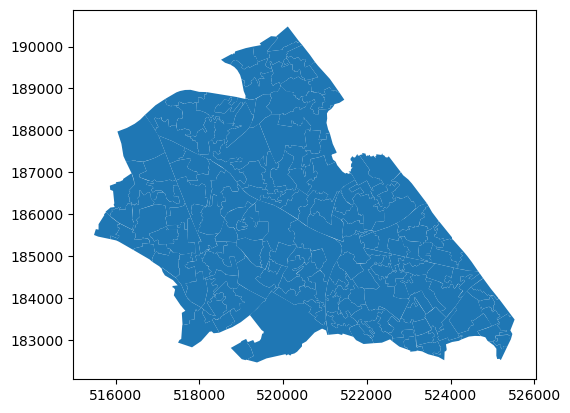

In [69]:
merge_london_simple[merge_london_simple['LSOA21NM'].str.contains('Brent')].plot()

In [70]:
#write to file
merge_london_simple.to_csv(census_opath / "london-2021-lsoa-simple.csv")

Given units for EPSG:27000 (BNG) are metres we also don't need multiple decimal places. We can remove as follows

In [71]:
# first step from https://gis.stackexchange.com/a/336382
merge_london_trunc = merge_london_simple.copy(deep=False)
merge_london_trunc.geometry = merge_london_simple.geometry.apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x,rounding_precision=0)))
merge_london_trunc.geometry = merge_london_trunc.geometry.apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x,trim=True)))

This also seems to have limited impact on visualisation (but will further reduce csv file size):

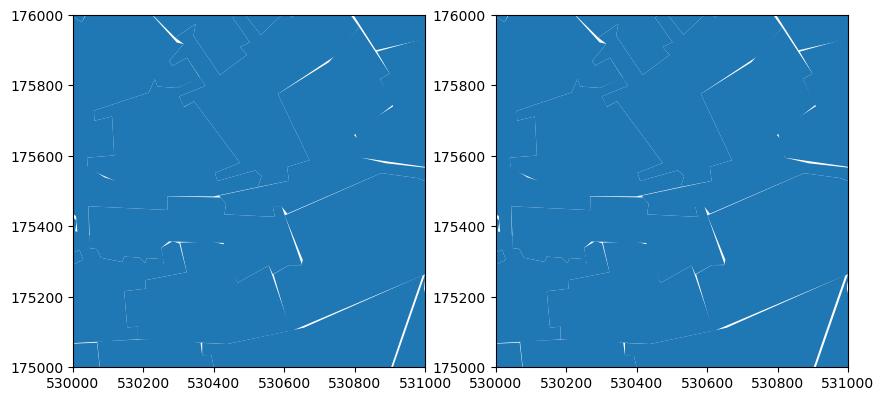

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
merge_london_simple.plot(ax=ax[0])
merge_london_trunc.plot(ax=ax[1])
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
plt.show()

<AxesSubplot:>

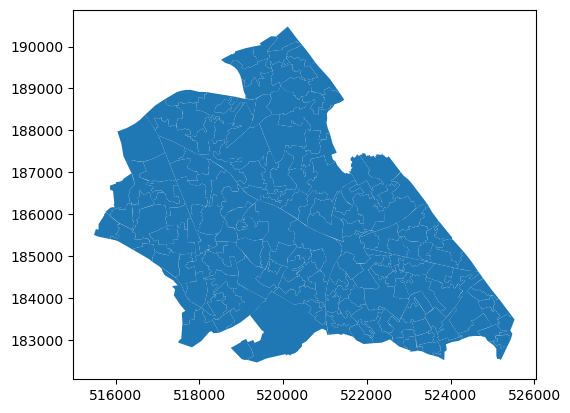

In [73]:
merge_london_trunc[merge_london_trunc['LSOA21NM'].str.contains('Brent')].plot()

So now we can write to file:

In [74]:
merge_london_trunc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4994 entries, 0 to 4993
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA21CD  4994 non-null   object  
 1   LSOA21NM  4994 non-null   string  
 2   MSOA21CD  4994 non-null   object  
 3   MSOA21NM  4994 non-null   object  
 4   LAD22CD   4994 non-null   object  
 5   LAD22NM   4994 non-null   object  
 6   geometry  4994 non-null   geometry
dtypes: geometry(1), object(5), string(1)
memory usage: 312.1+ KB


In [75]:
merge_london_trunc.to_csv(census_opath / "london-2021-lsoa-trunc.csv", index=False)

### Final checks

Read back in to check:

In [76]:
#https://gist.github.com/jamesdamillington/5f7c4c231b74a068be4cb232b1b9dea5
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads

file_path = census_opath / "london-2021-lsoa-trunc.csv"
geom_col = 'geometry'
epsg_id = 27700
crs_str = "EPSG:" + str(epsg_id) 

df = pd.read_csv(file_path)
gdf = gpd.GeoDataFrame(df)  #geopandas
gdf[geom_col] = gdf[geom_col].apply(lambda x: loads(x))  #from shapely
gdf = gdf.set_geometry(geom_col).set_crs(crs_str)

In [77]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA21CD  4994 non-null   object  
 1   LSOA21NM  4994 non-null   object  
 2   MSOA21CD  4994 non-null   object  
 3   MSOA21NM  4994 non-null   object  
 4   LAD22CD   4994 non-null   object  
 5   LAD22NM   4994 non-null   object  
 6   geometry  4994 non-null   geometry
dtypes: geometry(1), object(6)
memory usage: 273.2+ KB


<AxesSubplot:>

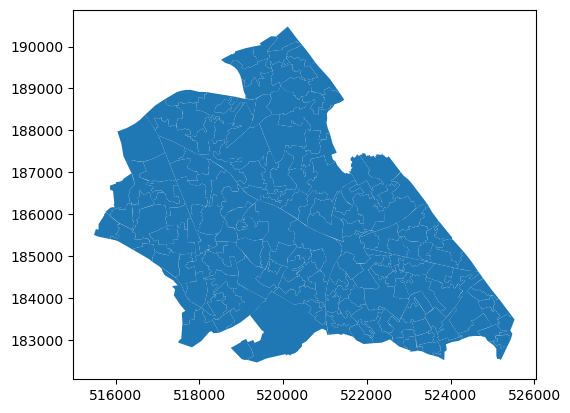

In [78]:
gdf[gdf['LSOA21NM'].str.contains('Brent')].plot()